In [1]:
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils import resample


In [2]:
# Pre-processing: rid of all columns that are mostly unfilled and patients who declined to answer a question
cerv_data = pd.read_csv('risk_factors_cervical_cancer.csv', na_values=["?"])
print(len(cerv_data.columns))
cerv_data = cerv_data.drop(columns =['STDs: Time since last diagnosis','STDs: Time since first diagnosis'])
impute = True
if impute:
    imp_mean = IterativeImputer(random_state=0)
    cols = cerv_data.columns
    cerv_data = pd.DataFrame(imp_mean.fit_transform(cerv_data), columns = cols)
else:
    cerv_data = cerv_data.dropna()
#imp_mean.transform(cerv_data)
#print(cerv_data)
x, y = cerv_data.iloc[:,:-4], cerv_data.iloc[:,-4:]
# print(x)
# print(y)
target_var_names = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']

36


In [3]:
#balanced data set dataframes
def random_undersample(cerv_data, target_var, random_state=None):
    positive_samples = cerv_data.loc[cerv_data[target_var] == 1]
    negative_samples = resample(cerv_data.loc[cerv_data[target_var] == 0],
                                replace=False,
                                n_samples=positive_samples.shape[0],
                                random_state=random_state)
    resampled_data = pd.concat([positive_samples, negative_samples])
    return resampled_data

hinselmann_bal = random_undersample(cerv_data, 'Hinselmann') #added for balanced dataset
schiller_bal = random_undersample(cerv_data, 'Schiller') #added for balanced dataset
citology_bal = random_undersample(cerv_data, 'Citology') #added for balanced dataset
biopsy_bal = random_undersample(cerv_data, 'Biopsy') #added for balanced dataset

In [4]:
###### Logistic regression ######
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import compute_sample_weight
from sklearn.metrics import confusion_matrix
from utils import *
from tabulate import tabulate

hinselmann, schiller, citology, biopsy = y.loc[:, 'Hinselmann'], y.loc[:, 'Schiller'], y.loc[:, 'Citology'], y.loc[:, 'Biopsy']
lr_pipe = Pipeline([('scale', StandardScaler()), ('logreg', LogisticRegression())])

# Direct fitting
def direct_fit_classifier(pipe, x, y, balanced_step_name=None):
    if balanced_step_name:
        fit_params = {'{0}__sample_weight'.format(balanced_step_name): compute_sample_weight('balanced', y)}
    else:
        fit_params = {}
    pipe.fit(x, y, **fit_params)
    return confusion_matrix(y, pipe.predict(x))

# Cross-validation
def cv_classifier(pipe, x, y, cv, balanced_step_name=None):
    ypred = np.empty(x.shape[0])
    for train_i, test_i in cv.split(x, y):
        if balanced_step_name:
            fit_params = {'{0}__sample_weight'.format(balanced_step_name): compute_sample_weight('balanced', y.iloc[train_i])}
        else:
            fit_params = {}
        pipe.fit(x.iloc[train_i], y.iloc[train_i], **fit_params)
        ypred[test_i] = pipe.predict(x.iloc[test_i])
    return confusion_matrix(y, ypred)

c_vals = np.logspace(-1, 0.1, 11)
table_rows = []
for outcome, name in zip([hinselmann, schiller, citology, biopsy],
                         ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']):
    name = outcome.name
    lr_cv_f1 = np.empty(len(c_vals))
    for i, c in enumerate(c_vals):
        lr_pipe['logreg'].C = c
        direct_cm = direct_fit_classifier(lr_pipe, x, outcome, 'logreg')
        cv_cm = cv_classifier(lr_pipe, x, outcome, StratifiedKFold(shuffle=True), 'logreg')
        lr_cv_f1[i] = get_f1_score(cv_cm)
    i = np.argmax(lr_cv_f1)
    # plt.figure()
    # plt.title(name)
    # plt.plot(c_vals, lr_cv_f1)
    table_rows.append([name, c_vals[i], lr_cv_f1[i]])
print('Logistic regression')
print(tabulate(table_rows, headers=['Test', 'Optimal C', 'F1 score upon CV']))
for outcome, name in zip([hinselmann_bal, schiller_bal, citology_bal, biopsy_bal],
                         ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']):
    xbal = outcome.iloc[:,:-4]      #added for balanced data set
    ybal = outcome.iloc[:,33]       #added for balanced data set
    direct_cm = direct_fit_classifier(lr_pipe, xbal, ybal, 'logreg')
    cv_cm = cv_classifier(lr_pipe, xbal, ybal, KFold(shuffle=True), 'logreg')

    display_model_stats(direct_cm, '{0} upon fitting'.format(name))

    display_model_stats(cv_cm, '{0} upon CV'.format(name))
    print('{0} F1 score with manual rebalancing: {1:.3}'.format(name, get_f1_score(cv_cm)))

Logistic regression
Test          Optimal C    F1 score upon CV
----------  -----------  ------------------
Hinselmann     0.275423            0.140351
Schiller       0.758578            0.251799
Citology       0.758578            0.124183
Biopsy         0.165959            0.221239


Hinselmann F1 score with manual rebalancing: 0.542


Schiller F1 score with manual rebalancing: 0.434


Citology F1 score with manual rebalancing: 0.196


Biopsy F1 score with manual rebalancing: 0.515


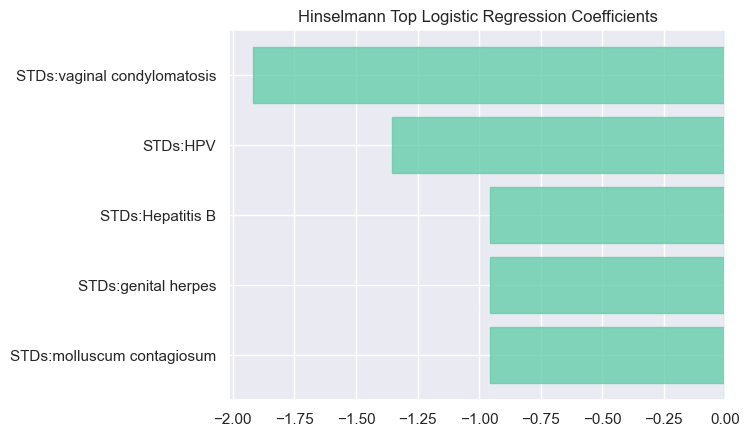

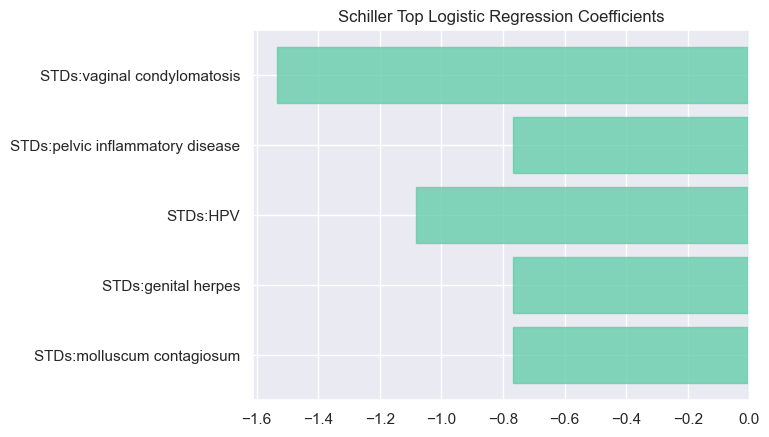

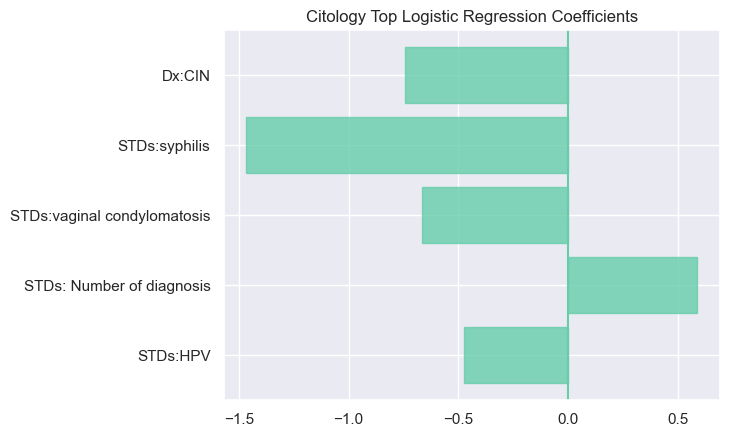

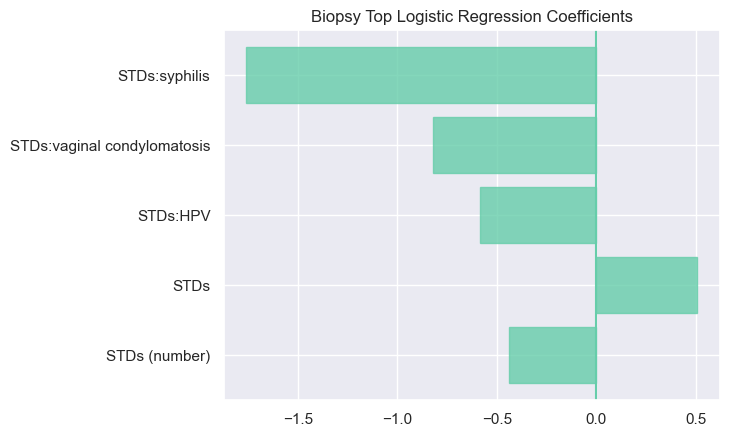

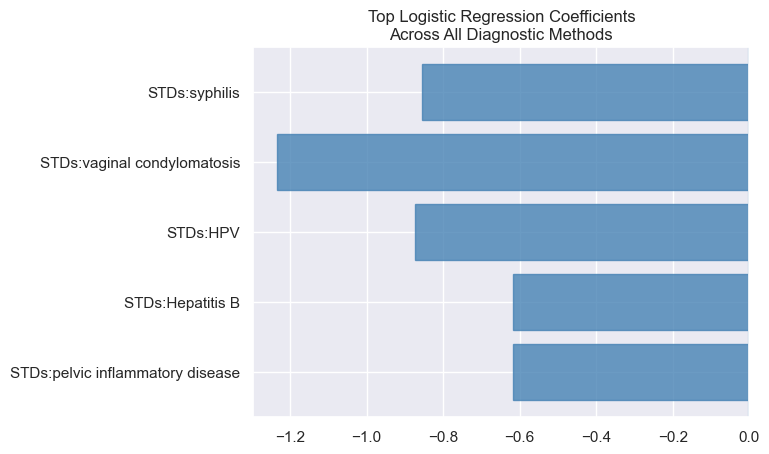

In [5]:
###### Logistic regression coefficients ######

lr_pipe_co = lr_pipe
coef_avg = np.empty(30)
for outcome, name in zip([hinselmann, schiller, citology, biopsy],
                             ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']):
    fit_params = {'logreg__sample_weight': compute_sample_weight('balanced', outcome)}
    lr_pipe_co.fit(x, outcome, **fit_params)
    lr_coefs = lr_pipe_co.named_steps['logreg'].coef_
    coef_avg = coef_avg + lr_coefs
    
    ind = np.argpartition(np.abs(lr_coefs), -5)[0][-5:]
    highest_weights = lr_coefs[0][ind]
    plt.figure()
    plt.barh(range(5), highest_weights, tick_label=x.columns[ind], 
             color='mediumaquamarine', alpha=0.8, ec='mediumaquamarine')
    plt.axvline(x=0, c='mediumaquamarine')
    plt.title(name + " Top Logistic Regression Coefficients")
    plt.savefig(f"figures/{name} logregresscoe.png", bbox_inches = 'tight', orientation = 'landscape')
 
#     print(lr_coefs[0][ind])
#     print(x.columns[ind])
# print(coef_avg/4)
# print(x.columns)
coef_avg = coef_avg/4
avg_ind = np.argpartition(np.abs(coef_avg), -5)[0][-5:]
avg_weights = coef_avg[0][avg_ind]
plt.figure()
plt.barh(range(5), avg_weights, tick_label=x.columns[avg_ind], 
         color='steelblue', alpha=0.8, ec='steelblue')
plt.axvline(x=0, c='steelblue')
plt.title("Top Logistic Regression Coefficients\nAcross All Diagnostic Methods")
plt.show()


Predicted   
                   -  +
                       
Observed -       823  0
         +        35  0

Predicted   
                   -  +
                       
Observed -       823  0
         +        35  0

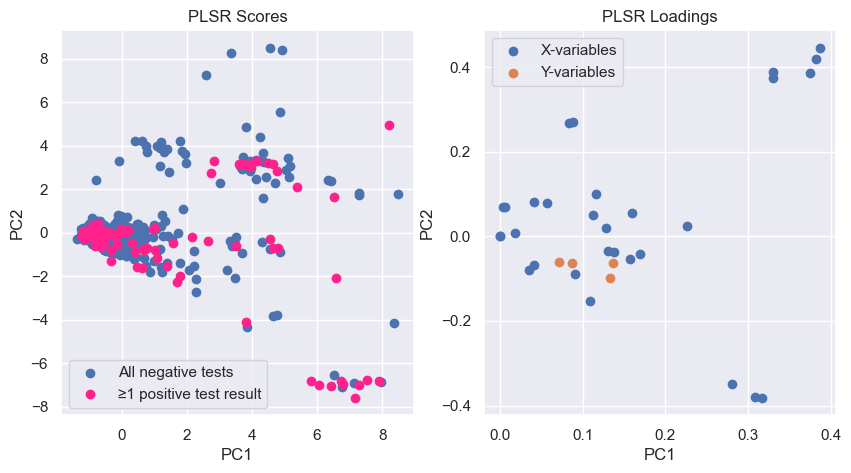

In [6]:
###### PLSR ######
from sklearn.cross_decomposition import PLSRegression

hinselpos = np.where(hinselmann == 1)
hinselneg = np.where(hinselmann == 0)
schpos = np.where(schiller == 1)
schneg = np.where(schiller == 0)
somepos, allneg = np.where(np.any(y == 1, axis=1)), np.where(np.all(y == 0, axis=1))

plsr = PLSRegression()
x_scores, y_scores = plsr.fit_transform(x, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set(xlabel='PC1', ylabel='PC2', title='PLSR Scores')
ax1.scatter(x_scores[allneg, 0], x_scores[allneg, 1], label='All negative tests')
ax1.scatter(x_scores[somepos, 0], x_scores[somepos, 1], color='#ff218c', label='≥1 positive test result')
plt.savefig("figures/negative plsr", dpi=200, orientation='landscape')
ax1.legend()
ax2.set(xlabel='PC1', ylabel='PC2', title='PLSR Loadings')
ax2.scatter(plsr.x_loadings_[:, 0], plsr.x_loadings_[:, 1], label='X-variables')
ax2.scatter(plsr.y_loadings_[:, 0], plsr.y_loadings_[:, 1], label='Y-variables')
ax2.legend()
plt.savefig("figures/loading.png", dpi=200, orientation='landscape')
# for i, yvar in enumerate(plsr.y_loadings_):
#     ax2.annotate(y.iloc[:, i].name, (yvar[0], yvar[1]))

plsr.fit(x, y)
ypred_plsr_direct = [1 if p > 0.5 else 0 for p in plsr.predict(x)[:, 0]]
print_confusion(confusion_matrix(y.iloc[:, 0], ypred_plsr_direct))

cv = KFold()
ypred_plsr = np.empty(y.shape)
for train_i, test_i in cv.split(x):
    # sampw = np.where(np.any(y.iloc[train_i, :] == 1, axis=1),
    #                  [30] * len(y.iloc[train_i, :]), [1] * len(y.iloc[train_i, :]))
    plsr.fit(x.iloc[train_i, :], y.iloc[train_i, :])
    for i, prediction in zip(test_i, plsr.predict(x.iloc[test_i, :])):
        ypred_plsr[i] = [1 if p > 0.5 else 0 for p in prediction]
        #print(prediction, ypred_plsr[i])

print_confusion(confusion_matrix(y.iloc[:, 0], ypred_plsr[:, 0]))

In [7]:
###### Random forest classifier ######
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from utils import *

# Can vary max depth to test different regularization strengths
rfc = Pipeline([('scale', StandardScaler()), ('random-forest', RandomForestClassifier())])
rfc.fit(x, citology)
rfccm_direct = confusion_matrix(citology, rfc.predict(x))
print_confusion(rfccm_direct)
print('F1 score upon fitting: {0:.4}'.format(get_f1_score(rfccm_direct)))

ypred = np.empty(x.shape[0])
for train_i, test_i in StratifiedKFold().split(x, citology):
    rfc.fit(x.iloc[train_i, :], citology.iloc[train_i])
    ypred[test_i] = rfc.predict(x.iloc[test_i, :])

rfccm = confusion_matrix(citology, ypred)
print_confusion(rfccm)
print('F1 score upon CV: {0:.4}'.format(get_f1_score(rfccm)))

Predicted    
                   -   +
                        
Observed -       814   0
         +         3  41

F1 score upon fitting: 0.9647


Predicted   
                   -  +
                       
Observed -       808  6
         +        41  3

F1 score upon CV: 0.1132


In [8]:
###### Support vector machines ######
#we will have to play with c value and kernel
svc_model = Pipeline([('scale', StandardScaler()), ('svm', SVC(C=1000, kernel='rbf'))])
hinselmann_arr = np.array(hinselmann)
svc_model.fit(x, hinselmann_arr)
hinselmann_predict = svc_model.predict(x)
#print(hinselmann_predict)
print(cv_classifier(svc_model, x, hinselmann, KFold()))

schiller_arr = np.array(schiller)
svc_model.fit(x, schiller_arr)
schiller_predict = svc_model.predict(x)
#print(schiller_predict)
print(cv_classifier(svc_model, x, schiller, KFold()))

citology_arr = np.array(citology)
svc_model.fit(x, citology_arr)
citology_predict = svc_model.predict(x)
#print(citology_predict)
print(cv_classifier(svc_model, x, citology, KFold()))

biopsy_arr = np.array(biopsy)
svc_model.fit(x, biopsy_arr)
biopsy_predict = svc_model.predict(x)
#print(biopsy_predict)
print(cv_classifier(svc_model, x, biopsy, KFold()))


[[810  13]
 [ 34   1]]
[[744  40]
 [ 59  15]]
[[786  28]
 [ 40   4]]
[[776  27]
 [ 48   7]]


In [9]:
tests = [hinselmann, schiller, citology, biopsy]
kernels_options = ['rbf', 'poly']
cv_data = np.zeros((4,2,20))
cv_FN = np.zeros((4,2,20))
cv_FP = np.zeros((4,2,20))
cv_f1 = np.zeros((4,2,20))
cv_mis = np.zeros((4,2,20))
c_values = np.logspace(-4,5,20)
manual_balance = True
for a in range(4):
    for i, b in enumerate(c_values):
        for c in range(2):
            svc_model = Pipeline([('scale', StandardScaler()),
                                  ('svm', SVC(C=b, kernel=kernels_options[c]))])
            if manual_balance:
                xbal = biopsy_bal.iloc[:,:-4]      #added for balanced data set
                ybal = biopsy_bal.iloc[:,33]       #added for balanced data set
                direct_cm = direct_fit_classifier(svc_model, xbal, ybal)#[a]) for balanced set
                cv_cm = cv_classifier(svc_model, xbal, ybal, KFold()) #tests[a] for balanced data set
            else:
                direct_cm = direct_fit_classifier(svc_model, x, tests[a])
                cv_cm = cv_classifier(svc_model, x, tests[a], KFold())
            #display_model_stats(direct_cm, '{0} upon fitting'.format(name))
            #display_model_stats(cv_cm, '{0} upon CV'.format(name))
            cv_data[a,c,i] = get_score(cv_cm)
            cv_FN[a,c,i] = get_fn_rate(cv_cm)
            cv_FP[a,c,i] = get_fp_rate(cv_cm)
            cv_f1[a,c,i] = get_f1_score(cv_cm)
            cv_mis[a,c,i] = misclassification(cv_cm)
            print(tests[a].name, kernels_options[c], b)
            #print(tests[a])
            #print(kernels_options[c])
            #print(c_values[i])
    

Hinselmann rbf 0.0001
Hinselmann poly 0.0001
Hinselmann rbf 0.00029763514416313193
Hinselmann poly 0.00029763514416313193
Hinselmann rbf 0.0008858667904100823
Hinselmann poly 0.0008858667904100823
Hinselmann rbf 0.0026366508987303583
Hinselmann poly 0.0026366508987303583
Hinselmann rbf 0.007847599703514606
Hinselmann poly 0.007847599703514606
Hinselmann rbf 0.023357214690901212
Hinselmann poly 0.023357214690901212
Hinselmann rbf 0.06951927961775606
Hinselmann poly 0.06951927961775606
Hinselmann rbf 0.2069138081114788
Hinselmann poly 0.2069138081114788
Hinselmann rbf 0.615848211066026
Hinselmann poly 0.615848211066026
Hinselmann rbf 1.8329807108324339
Hinselmann poly 1.8329807108324339
Hinselmann rbf 5.455594781168514
Hinselmann poly 5.455594781168514
Hinselmann rbf 16.23776739188721
Hinselmann poly 16.23776739188721
Hinselmann rbf 48.32930238571752
Hinselmann poly 48.32930238571752
Hinselmann rbf 143.8449888287663
Hinselmann poly 143.8449888287663
Hinselmann rbf 428.1332398719387
Hinse

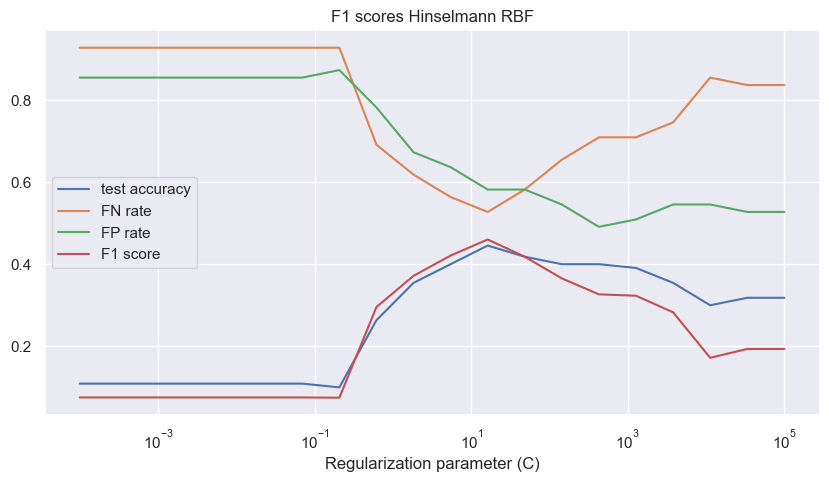

11
11


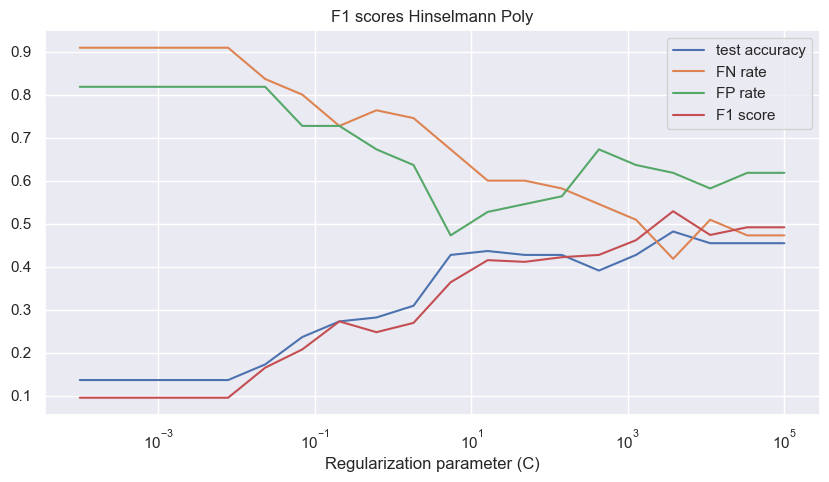

16
16


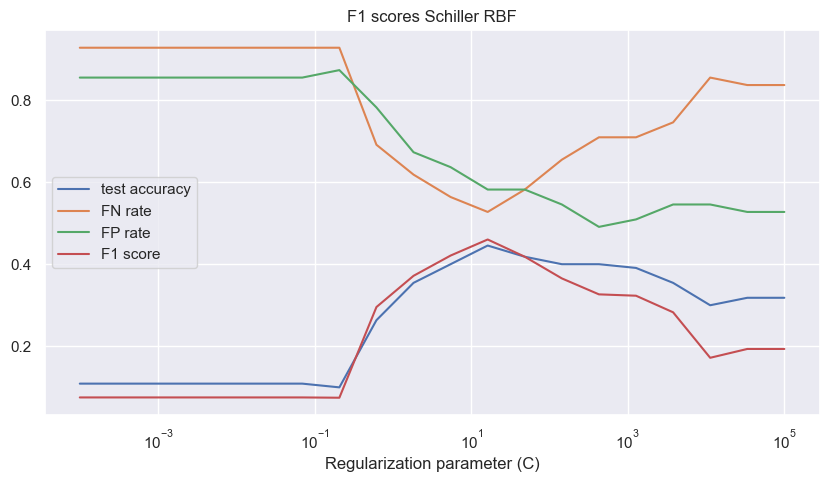

11
11


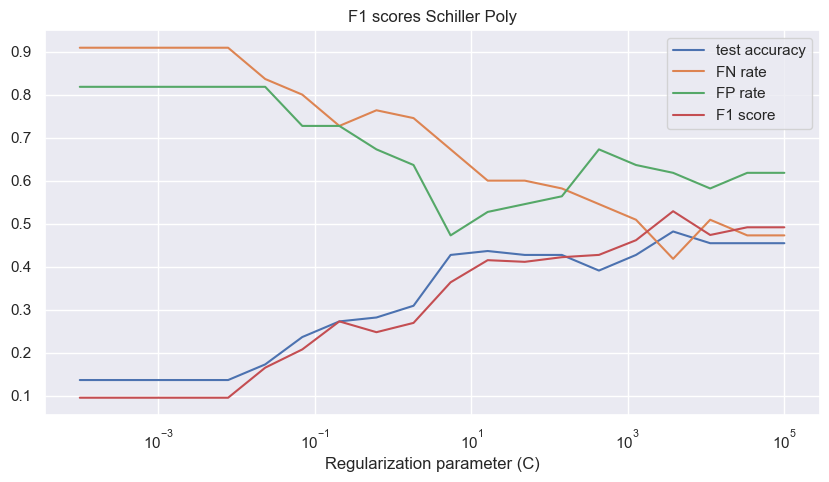

16
16


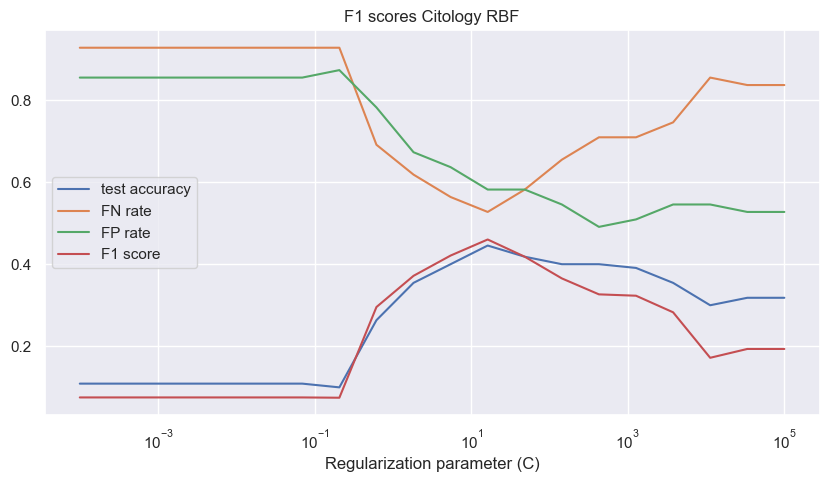

11
11


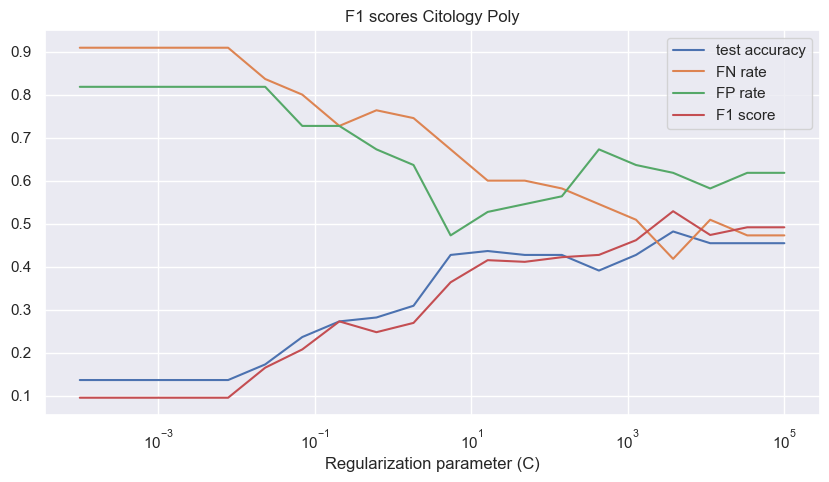

16
16


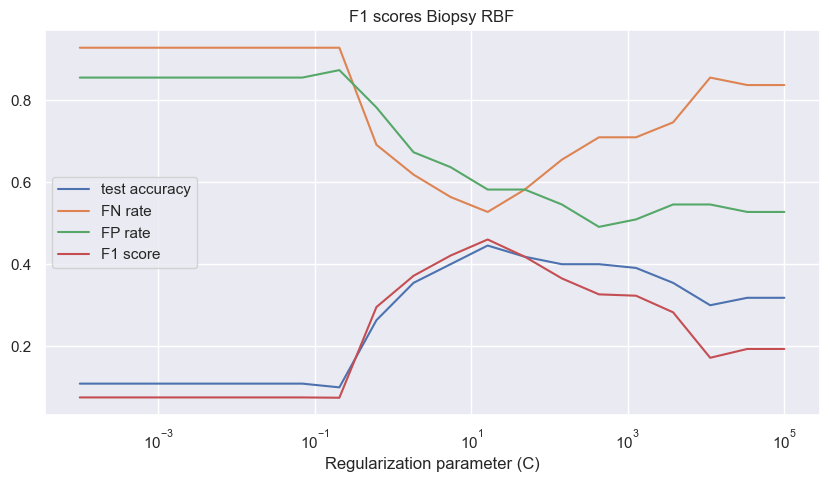

11
11


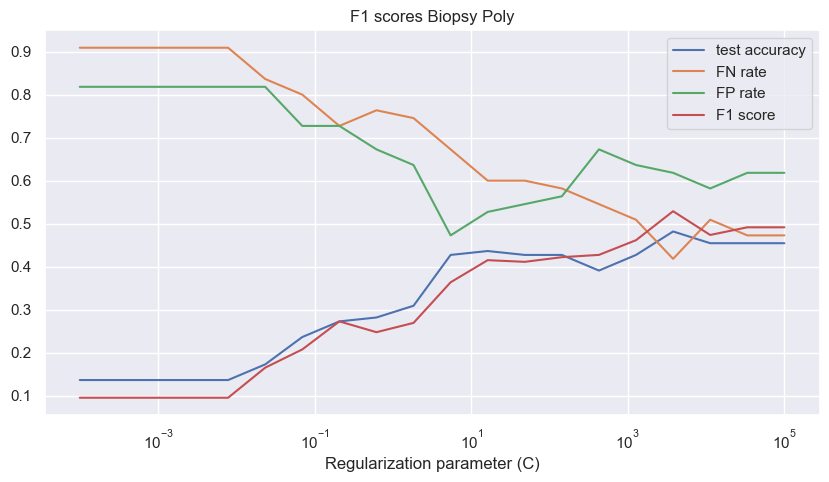

16
16


In [10]:
## F1 score
for a, target_var in enumerate(target_var_names):
    for b, kernel_name in enumerate(['RBF', 'Poly']):
        plt.figure(figsize=(10,5))
        plt.plot(c_values,cv_data[a,b,:], label = 'test accuracy')
        plt.plot(c_values,cv_FN[a,b,:], label = 'FN rate')
        plt.plot(c_values,cv_FP[a,b,:], label = 'FP rate')
        plt.plot(c_values,cv_f1[a,b,:], label = 'F1 score')
        #plt.title('{0} {1}'.format(tests[a].name, kernels_options[b]))
        plt.xscale('log')
        plt.xlabel('Regularization parameter (C)')
        plt.legend()
        plt.title('F1 scores {0} {1}'.format(target_var, kernel_name))
        plt.savefig('figures/f1scores_{0}_{1}.png'.format(target_var, kernel_name),
                    dpi=200, orientation='landscape')
                
        plt.show()
        print(np.argmax(cv_f1[a,b,:]))
        print(np.argmin(cv_mis[a,b,:]))
        
